# Predictive elicitation

The examples below can be executed from within this page thanks to embedded integration with Binder via Thebe.
Click on the button below and start playing with PreliZ right from your browser or open this notebook on Binder directly [![badge](https://img.shields.io/badge/launch-binder-579ACA.svg?logo=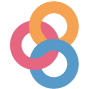)](https://mybinder.org/v2/gh/arviz-devs/arviz_sandbox/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Farviz-devs%252Fpreliz%26urlpath%3Dtree%252Fpreliz%252Fdocs%252Fexamples%252Fobserved_space_examples.ipynb%26branch%3Dmain)


:::{thebe-button}
:::

In [ ]:
# latest PreliZ might not be installed
import sys

!{sys.executable} -m pip install preliz@git+https://github.com/arviz-devs/preliz.git

In [3]:
import arviz as az
import preliz as pz
import numpy as np

In [4]:
az.style.use("arviz-white")

Predictive elicitation refers to the elicitation of priors by making evaluations on the observed space, instead of the parameters space. The advantage of the former is that generally it is easier to think about observations than parameters, specially for domain experts. If you are a forest engineer, you may be more familiar with the expected rate of wildfires in an area than with the `rho` parameter of a model.

Currently PreliZ provides 3 functions for predictive elicitation. Most of the future development of PreliZ will be focused on improving these tools and providing other tools for predictive elicitation.

(predictive_explorer)=

## Predictive explorer

This function will automatically generate textboxes for a function, which makes it easier to explore how the prior predictive distribution changes when we change the priors.

So suppose you already have a model, but you are unsure about the implications of its parameters. You can write it using PreliZ distributions and put it inside a function with the arguments being the parameters you want to explore.

In [5]:
x = np.linspace(0, 1, 100)

def a_preliz_model(a_mu, a_sigma, c_sigma=1):
    a = pz.Normal(a_mu, a_sigma).rvs()
    c = pz.Gamma(mu=2, sigma=c_sigma).rvs()
    b = pz.Normal(np.exp(a)*x, c).rvs()
    return b

By calling `predictive_explorer` you will get textboxes with some default initial values and for you to explore.

In [6]:
pz.predictive_explorer(a_preliz_model)

 After the parameter name, you will see a tuple indicating the valid range of the parameter. These values are inferred automatically by `predictive_explorer`. Currently, we use a very simple heuristic to find the range, so take the suggestion with a pinch of salt

`predictive_explorer` supports three types of plots: empirical cumulative distribution functions (CDFs), kernel density estimations (KDEs), and histograms. 
Additionally, you can also add custom Matplotlib code using the `plot_func` parameter.

In [7]:
# Custom function to plot a histogram
def custom_hist(predictions, ax):
    ax.hist(predictions.flatten(), bins='auto', alpha=0.7)

In [8]:
# plot_func set to custom_hist
pz.predictive_explorer(a_preliz_model, samples=10, plot_func=custom_hist)

(prior_predictive_assistant)=

## Prior predictive assistant

Now we will see a very experimental tool called "prior predictive assistant" (ppa for short). Suppose we have a model and we want to explore the prior predictive distribution and if possible refine the priors in our model. A common scenario in practice is that after some thinking we are able to define a model, but our priors are still too wide, as we are underusing our prior knowledge.

Let assume a Normal model with an unknown mean and standard deviation, here `a` and `b` represent our priors and `y` the likelihood.

In [9]:
np.random.seed(1237)
def a_preliz_model():
    a = pz.Normal(0, 10).rvs()
    b = pz.HalfNormal(10).rvs()
    y = pz.Normal(a, b).rvs(100)
    return a, b, y

"This is an experimental method under development, use with caution.


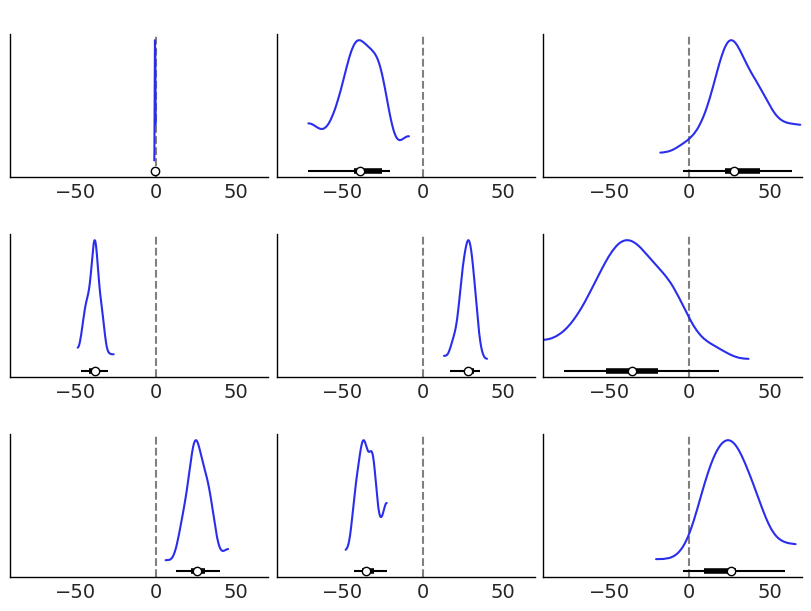

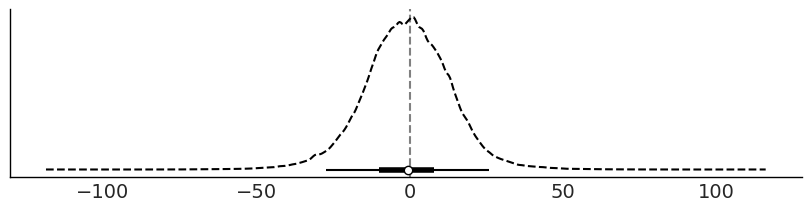

In [10]:
%matplotlib widget
pz.ppa(a_preliz_model)

The `ppa` function will take the function `a_preliz_model` and generate 2000 samples from the prior (`a`, `b`) and prior_predictive distribution `y`. Then it will automatically select 9 samples from the prior_predictive distribution (the blue distributions in the 3x3 grid). At the bottom (black dashed line) we have a plot of the 2000 samples altogether. 
 
Then, from the 3x3 grid, we can select one or more samples that match our domain knowledge. If we click on the `carry on` button we will get a new set of samples from the prior predictive distribution. The bottom panel will automatically update to reflect all previously selected samples. Once we have selected a few distributions we click on the `return prior` button to get a prior that agrees with the selected predictive distributions. 

Four important aspects when trying `ppa` is that:

* We want to select distributions based on prior information and NOT based on the observed data we want to fit.

* The more distributions we select the more accurate the results should be.

* The returned prior is just a suggestion, to be sure the suggestion is useful you may want to try `ppa` a couple of times and see how variable results are and do further tests like using `predictive_explorer`

* This is experimental, both in the sense the code may have bugs and in the sense that the methodology could be dubious, or at least unrefined 


A few more details about what is going on under the hood


By default, the first set of samples is selected at random but tries to return a diverse subset. At any point, you can click on the `carry on` button. Even when we have not selected any distribution, in such a case we will get a new set of samples and the bottom panel will not be updated, simply because the selected set of distributions remains the same. After we have selected at least one sample, the following samples that are shown will be chosen to be similar to the previously selected ones. But if you keep clicking on the `carry on` button, eventually `ppa` is going to return random samples again. Every time we select a sample, `ppa` will try to select a few more for us, we are not able to directly see them but they are going to affect the bottom panel, so we can monitor that `ppa` did not select something too far or different from what we want. 

Alternatively to the random initialization, we can provide information to `ppa` about our prior knowledge by passing the `init` argument. If that's the case, then `ppa` will first show 9 samples to be as close as possible to what is specified by `init`. Currently, we have two options, pass a PreliZ distribution or a 2-tuple with the first element representing the mean and the second, the standard deviation. There is also a `boundaries` argument, that we can use to specify hard lower and/or upper boundaries. Samples with values outside these boundaries will not be available for selection, either by the user or `ppa`. Essentially, those samples will be discarded.

`ppa` returns two sets of priors:

* One that is restricted to return a prior on the same family as specified in the PreliZ model, in this example the prior for `a` will always be `Normal` and the prior for `b`, `HalfNormal`. 
* One that can select new families. We are currently exploring how to do this properly and what limitations this has, for example, it is expected that we will need to select more distributions to trust these results that the ones with the original families. Also we may want to have more control over which other families we want, like explicitly define them or add some restrictions like "positive distributions" only.


If you are unable to run this notebook, you can get a glimpse of `ppa` from this gif:


![ppa](ppa.gif)

(predictive_finder)=

## Predictive finder

This function is also experimental and similar to `pz.ppa`. You need to provide a model. The model is slightly different compared to the model you pass to `pz.ppa` (this will be unified in the future). The difference is that the function/model needs as argument the parameters from the prior that you want to change. In this example a0=0, a1=1, b0=1.

In [11]:
size = 100
def a_preliz_model(a0=0, a1=1, b0=1):
    a = pz.Normal(a0, a1).rvs()
    b = pz.HalfNormal(b0).rvs()
    y = pz.Normal(a, b).rvs(size)
    return a, b, y

Additionally, you have to provide a target distribution. This distribution should reflect your prior knowledge. That is, it should reflect how you think the data is distributed in general (not your observed data). For instance, if you are studying heart rate at rest you may state that a priori you expect the data to be distributed as `pz.maxent(pz.Gamma(), 40, 120, 0.95)`, being 40 a value for a well-trained athlete and 120 a value for a person with not very good cardiovascular condition.  You can use other PreliZ function to obtain such distributions like `pz.roulette`, `pz.quantile_int`, etc.

For this example just let say that our target is:

In [12]:
target = pz.Normal(-2.5, 2)

With this two element we are ready to call `predictive_finder`. The blue line shows you target distribution, the gray lines samples from prior predictive distribution and the dashed black line the mean of these samples.

This is an experimental method under development, use with caution.


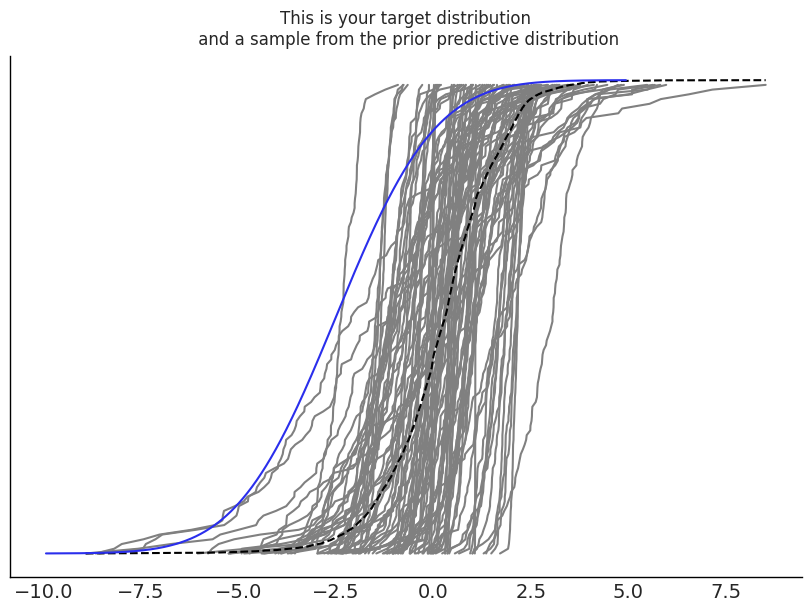

In [13]:
pz.predictive_finder(a_preliz_model, target)

`pz.predictive_finder` works iteratively. Each time you click on the figure or on the `carry_on` buttons it performs a numbers of steps (you can change this with the `steps` argument when calling the function). At each step will use the previous match as initial guess. If your initial prior predictive distribution is far from the target distribution you may need to increase the number of steps. Alternatively, you can click on the plot or press the `carry on` button many times. Once you visually check that the target and prior predictive distributions are close enough you can press the `return prior` button to get a new set of priors.

We have only tested `pz.predictive_finder` on a few simple models so if you are brave enough to use it, be also careful enough with the results.